## Analyse the results



In [4]:
# load the relevant modules for the analysis

import os
from pathlib import Path

import emcee
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from pl_temp_fit import Exp_data_utils, config_utils

os.chdir("/media/mohammed/Work/pl_temp_fit/")
# access the right directory
# os.chdir('C:\\Users\\ma11115\\OneDrive - Imperial College London\\pl_temp_fit')

In [39]:


databse_path = Path("fit_experimental_emcee_pl/fit_data_base/")
json_files = list(databse_path.glob("*.json"))
list_model_config = []
for _id, json_file in enumerate(json_files):
    model_config, model_config_save = config_utils.load_model_config(
        json_file.name.replace(".json", ""),
        database_folder=databse_path,
    )
    if os.path.exists(model_config_save["save_folder"] + "/sampler.h5"):
        filename = model_config_save["save_folder"] + "/sampler.h5"
        try:
            reader = emcee.backends.HDFBackend(filename, name="multi_core")
            if not reader.initialized:
                print("multi_core empty file")
                continue
            if reader.iteration == 0:
                print("empty file")
                continue
            distribution = reader.get_chain(flat=True)
        except AttributeError:
            print("check if single core")

            reader = emcee.backends.HDFBackend(filename, name="single_core")
            if not reader.initialized:
                print("empty file")
                continue
            distribution = reader.get_chain(flat=True)

        true_parameters = list(np.mean(distribution, axis=0))
        model_config_save["mean"] = [f"{x:.3f}" for x in true_parameters]
        model_config_save["num_iteration"] = reader.iteration
        log_prob = reader.get_log_prob(flat=True)
        model_config_save["max_log_prob"] = np.max(log_prob)

        list_model_config.append(model_config_save)
if len(list_model_config) == 0:
    print("no data")
else:
    df_all = pd.DataFrame(list_model_config)
    df_all.sort_values(by="date", ascending=False, inplace=True)
df_all[["csv_name_pl", "num_iteration", "max_log_prob"]]

,csv_name_pl,num_iteration,max_log_prob
0,/media/mohammed/Work/fit_pl_database_Hanbo/cry...,309,-671.465489


In [40]:
index_analyse = 0
test_id = df_all["test_id"].loc[index_analyse]
model_config, model_config_save = config_utils.load_model_config(
    test_id, database_folder=databse_path
)
filename = model_config_save["save_folder"] + "/sampler.h5"
reader = emcee.backends.HDFBackend(filename, name="multi_core")
distribution = reader.get_chain(discard=0, flat=True)

number of iterations 348
-639.3656353204465


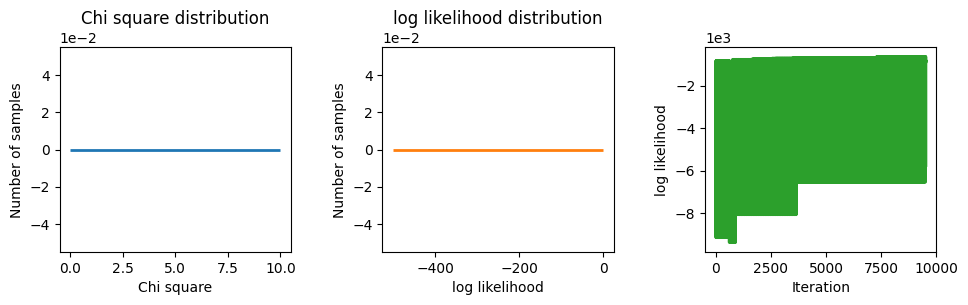

In [50]:
import importlib

from pl_temp_fit import plot_utils

importlib.reload(plot_utils)
plot_utils.plot_fit_statistics(
    reader,
    range_log_prior=(-500, 0),
    discard=50,
    range_chi_square=(0, 10),
    filter_log_likelihood=True,
)

(<Figure size 1000x900 with 6 Axes>,
 array([<Axes: ylabel='EX_E'>, <Axes: ylabel='EX_sigma'>,
        <Axes: ylabel='EX_Li'>, <Axes: ylabel='EX_Lo'>,
        <Axes: ylabel='EX_hO'>,
        <Axes: xlabel='step number', ylabel='EX_disorder_ext'>],
       dtype=object))

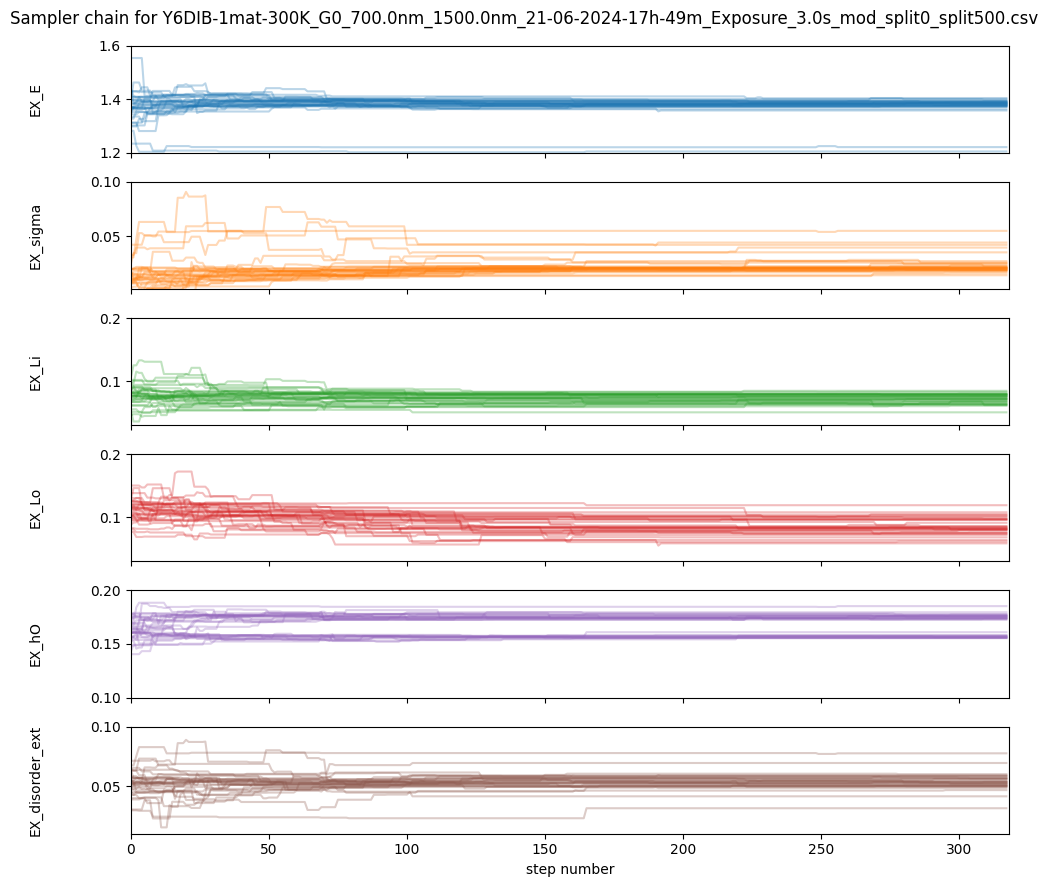

In [44]:
plot_utils.plot_chains(reader, model_config_save, discard=0)

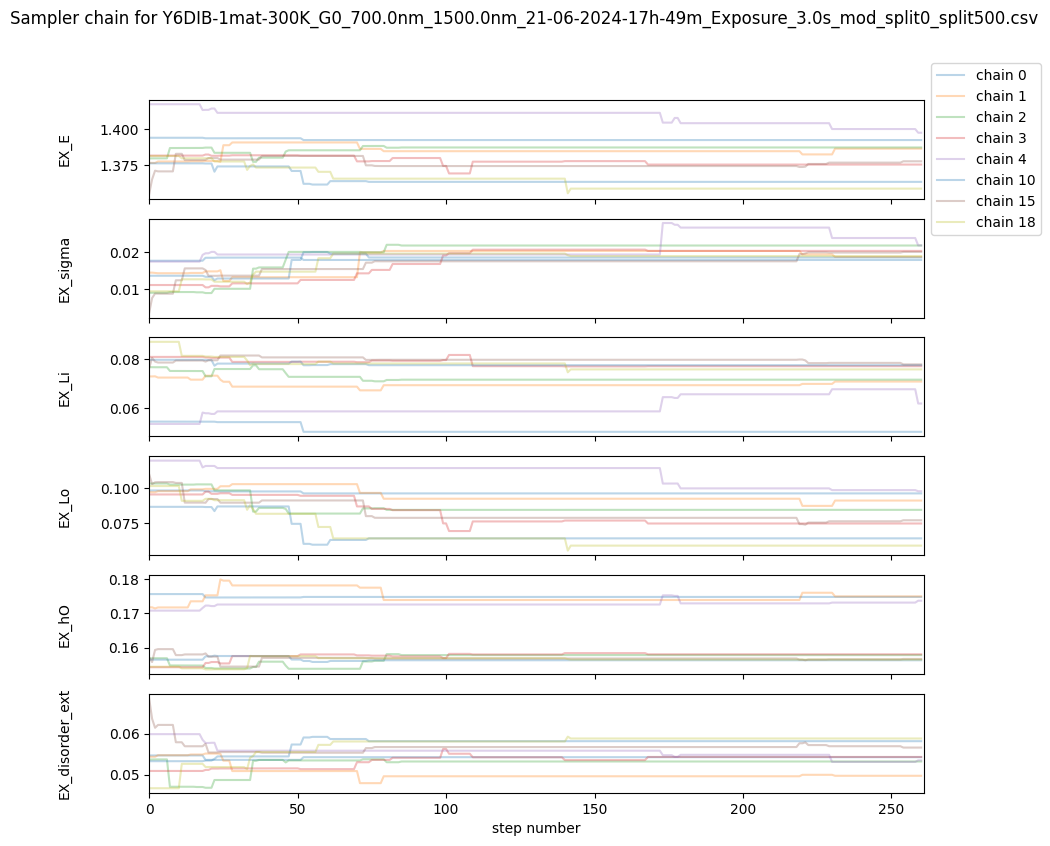

In [43]:
plot_utils.plot_diff_chains(
    reader,
    model_config_save,
    discard=50,
    chains_list=[0, 1, 2, 3, 4, 10, 15, 18],
)

(1.0, 1.6)

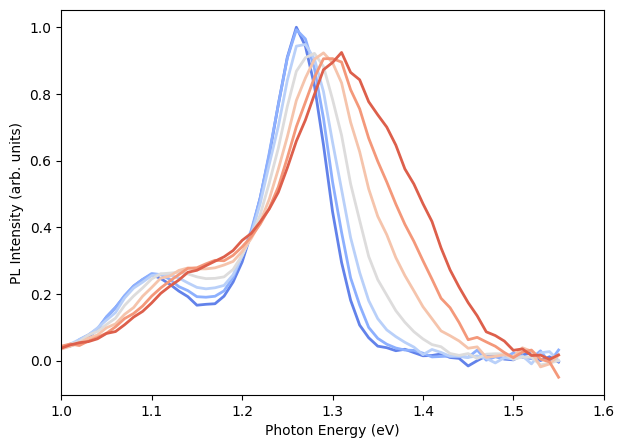

In [45]:
def plot_pl_data(
    truemodel_pl, temperature_list, hws, title="Experimental Data"
):
    fig, ax = plt.subplots(1, 1, figsize=(7, 5))

    data_true_plot = truemodel_pl.reshape(len(hws), -1) / max(
        truemodel_pl.reshape(-1, 1)
    )
    import seaborn as sns

    color_list = sns.color_palette("coolwarm", len(temperature_list))
    for i in range(len(temperature_list)):
        ax.plot(
            hws,
            data_true_plot[:, i],
            label="" + str(temperature_list[i]) + " K",
            # linestyle="--",
            color=color_list[i],
            linewidth=2,
        )

    ax.set_xlabel("Photon Energy (eV)")
    ax.set_ylabel("PL Intensity (arb. units)")

    return fig, ax


csv_name = model_config_save["csv_name_pl"]
Exp_data, temperature_list, hws = Exp_data_utils.read_data(csv_name)
fig, ax = plot_pl_data(
    Exp_data, temperature_list, hws, title="Experimental Data"
)
ax.set_xlim(1, 1.6)

shape of mean value plot is (61, 7)


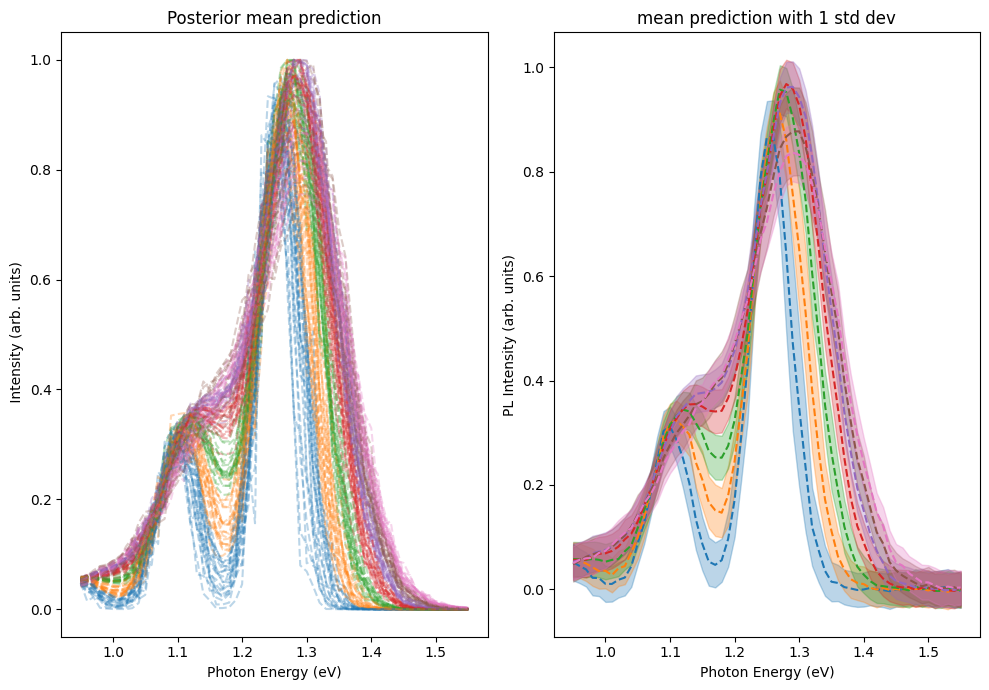

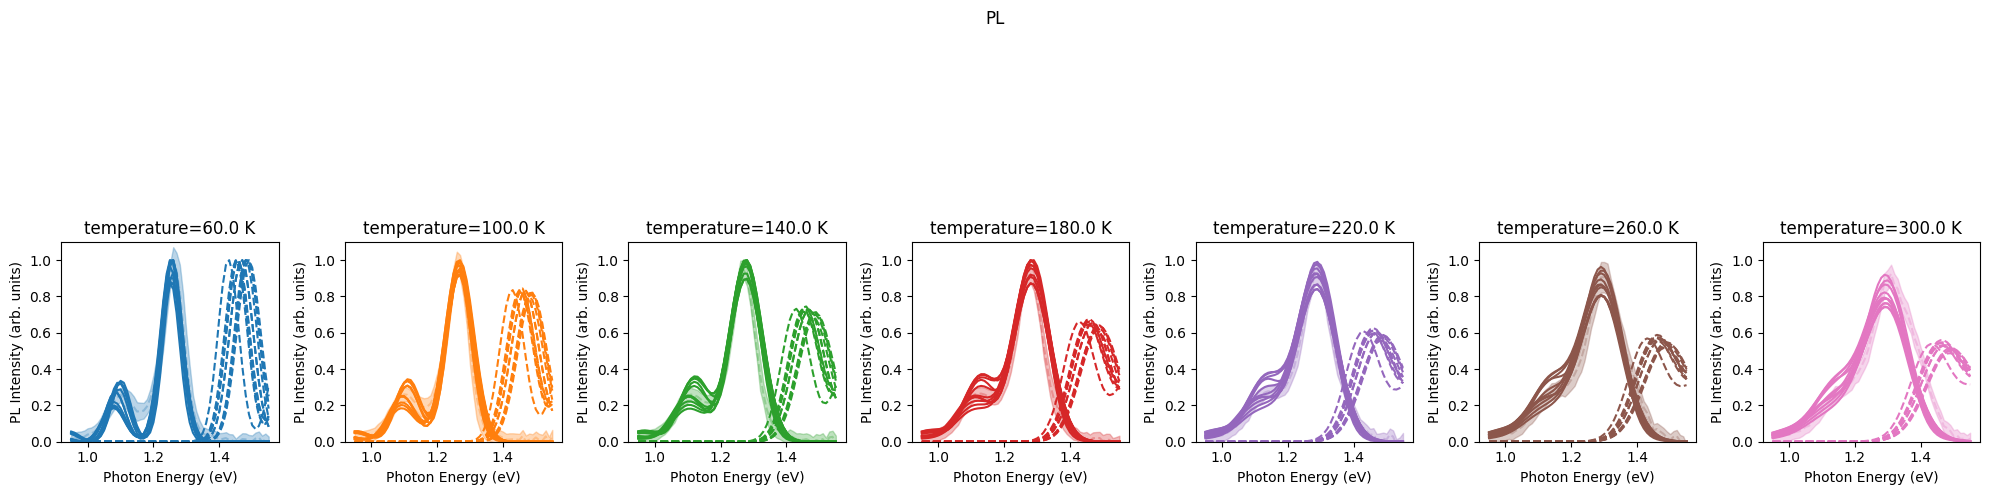

In [51]:
filter_log_likelihood = "blobs['log_likelihood'] > max(blobs['log_likelihood']) * 2"
            
plot_utils.plot_fit_to_experimental_data(
    model_config_save,
    model_config,
    reader,
    discard=50,
    filter_log_likelihood=filter_log_likelihood,
)

(<Figure size 1000x700 with 6 Axes>,
 array([<Axes: ylabel='EX_E'>, <Axes: ylabel='EX_sigma'>,
        <Axes: ylabel='EX_Li'>, <Axes: ylabel='EX_Lo'>,
        <Axes: ylabel='EX_hO'>, <Axes: ylabel='EX_disorder_ext'>],
       dtype=object))

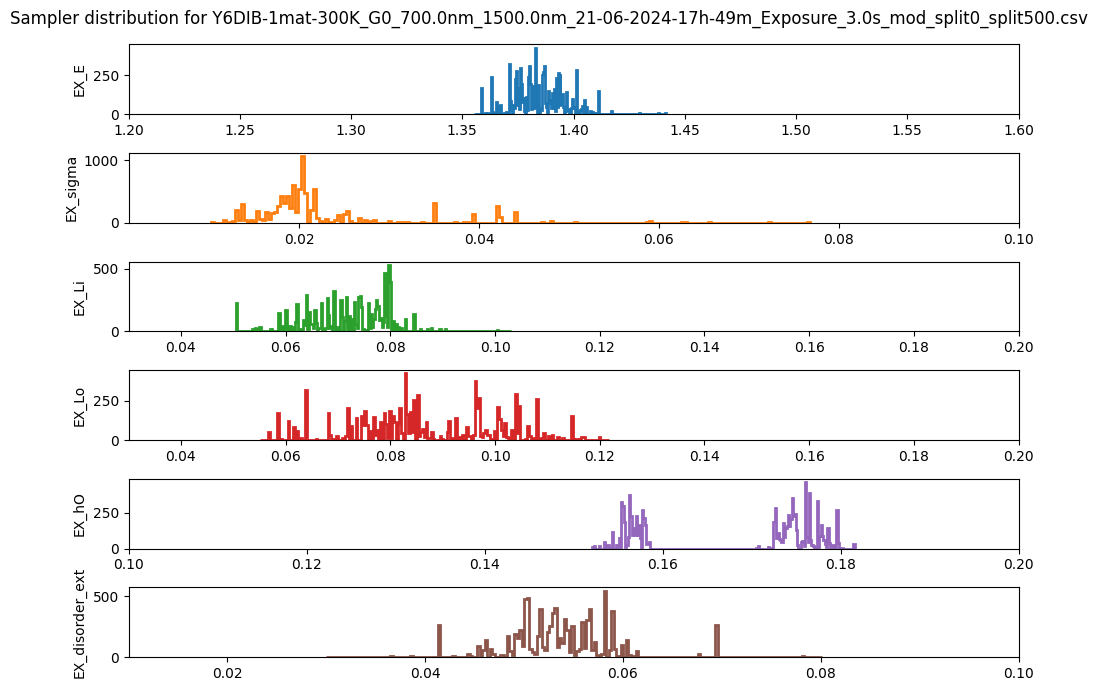

In [52]:
importlib.reload(plot_utils)
plot_utils.plot_distribution(
    reader, model_config_save, discard=50, filter_log_likelihood=filter_log_likelihood
)

(<Figure size 1500x1500 with 27 Axes>,
 array([[<Axes: ylabel='EX_E'>, None, None, None, None, None],
        [<Axes: xlabel='EX_E', ylabel='EX_sigma'>, <Axes: >, None, None,
         None, None],
        [<Axes: xlabel='EX_E', ylabel='EX_Li'>,
         <Axes: xlabel='EX_sigma', ylabel='EX_Li'>, <Axes: >, None, None,
         None],
        [<Axes: xlabel='EX_E', ylabel='EX_Lo'>,
         <Axes: xlabel='EX_sigma', ylabel='EX_Lo'>,
         <Axes: xlabel='EX_Li', ylabel='EX_Lo'>, <Axes: >, None, None],
        [<Axes: xlabel='EX_E', ylabel='EX_hO'>,
         <Axes: xlabel='EX_sigma', ylabel='EX_hO'>,
         <Axes: xlabel='EX_Li', ylabel='EX_hO'>,
         <Axes: xlabel='EX_Lo', ylabel='EX_hO'>, <Axes: >, None],
        [<Axes: xlabel='EX_E', ylabel='EX_disorder_ext'>,
         <Axes: xlabel='EX_sigma', ylabel='EX_disorder_ext'>,
         <Axes: xlabel='EX_Li', ylabel='EX_disorder_ext'>,
         <Axes: xlabel='EX_Lo', ylabel='EX_disorder_ext'>,
         <Axes: xlabel='EX_hO', ylabel='

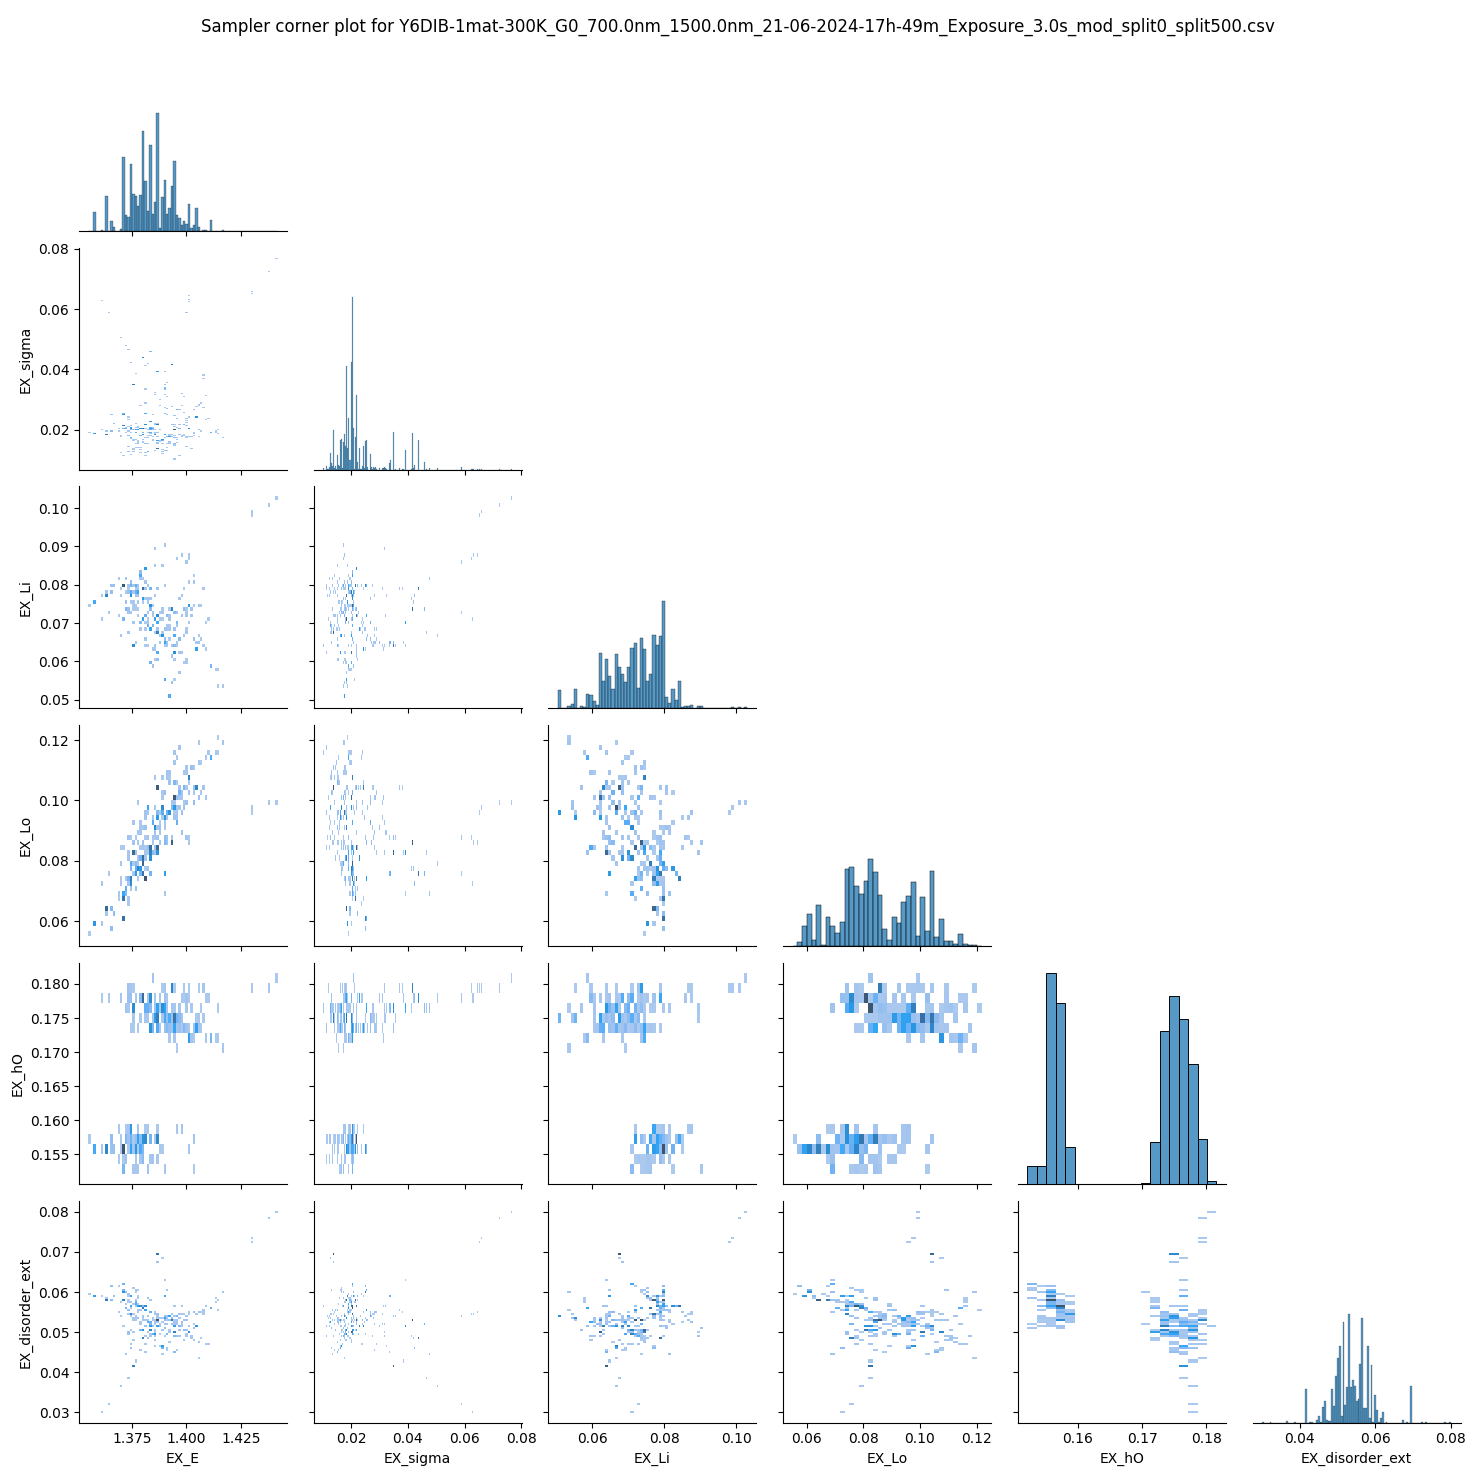

In [61]:
plot_utils.plot_corner(
    reader, model_config_save, discard=50, filter_log_likelihood=filter_log_likelihood
)

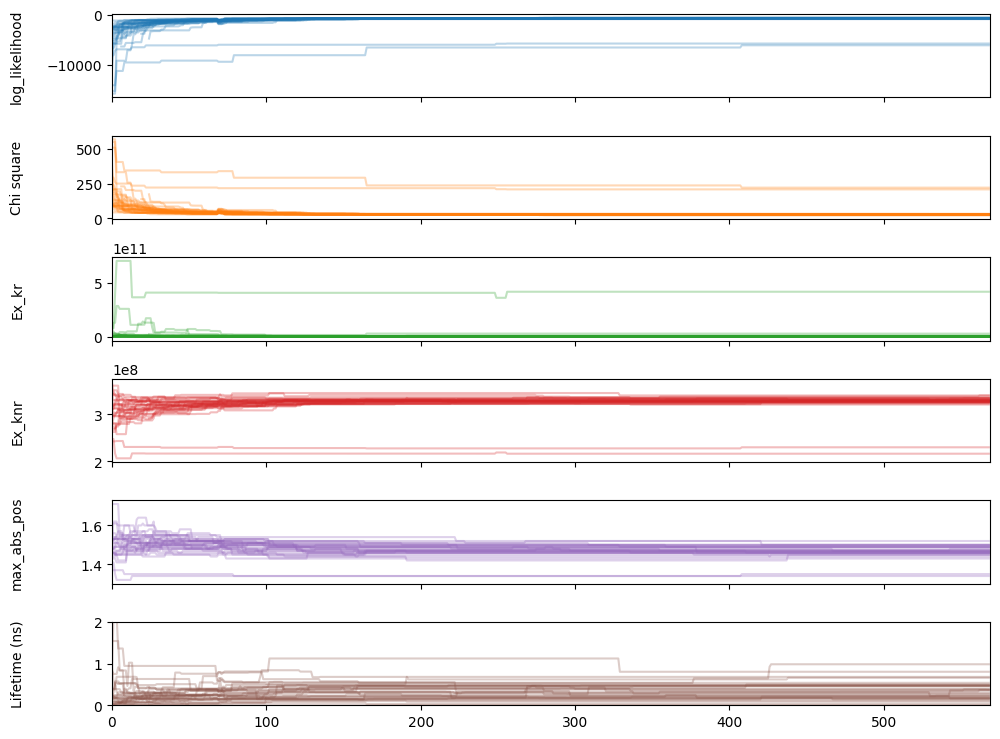

In [59]:
def plot_blobs_chain(reader, model_config_save, discard=0, filter_log_likelihood=None):
    blobs = reader.get_blobs(discard=discard)
    num_blobs = len(blobs.dtype.names)
    fig, axes = plt.subplots(num_blobs+1, figsize=(10, 1.5*num_blobs), sharex=True)
    for i in range(num_blobs):
        ax = axes[i]
        ax.plot(blobs[blobs.dtype.names[i]], alpha=0.3, color="C" + str(i))
        ax.set_xlim(0, len(blobs))
        ax.set_ylabel(blobs.dtype.names[i])
        ax.yaxis.set_label_coords(-0.1, 0.5)
    lifetime = 1/(blobs["Ex_kr"]+blobs["Ex_knr"]) *1e9
    ax = axes[i+1]
    ax.plot(lifetime, alpha=0.3, color="C" + str(i+1))
    ax.set_xlim(0, len(blobs))
    ax.set_ylabel("Lifetime (ns)")
    ax.yaxis.set_label_coords(-0.1, 0.5)
    ax.set_ylim(0, 2)
    fig.tight_layout()


plot_blobs_chain(reader, model_config_save, discard=0)

number of iterations 569


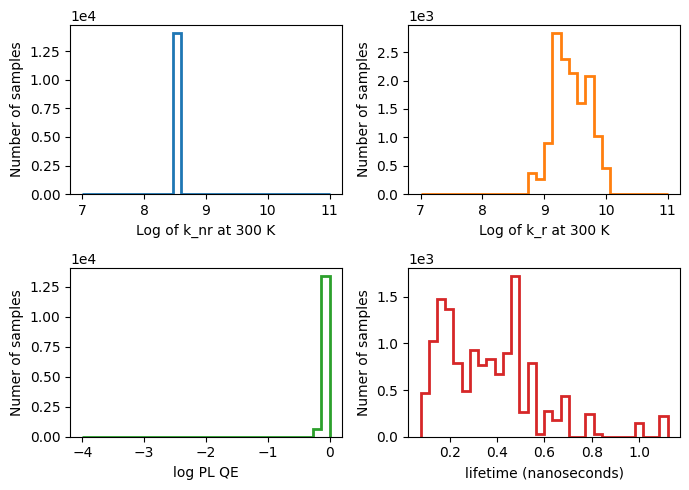

(<Figure size 700x500 with 4 Axes>,
 array([<Axes: xlabel='Log of k_nr at 300 K', ylabel='Number of samples'>,
        <Axes: xlabel='Log of k_r at 300 K', ylabel='Number of samples'>,
        <Axes: xlabel='log PL QE', ylabel='Numer of samples'>,
        <Axes: xlabel='lifetime (nanoseconds)', ylabel='Numer of samples'>],
       dtype=object))

In [60]:
plot_utils.plot_lifetime(reader, discard=100, filter_log_likelihood=filter_log_likelihood)

number of iterations 300
-39.91561300272554


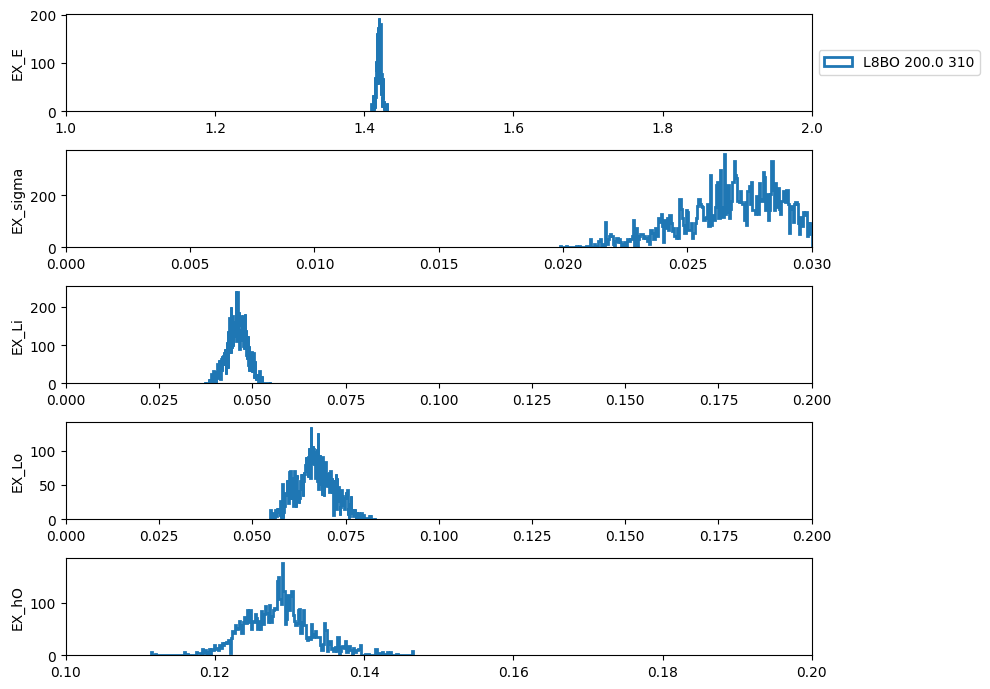

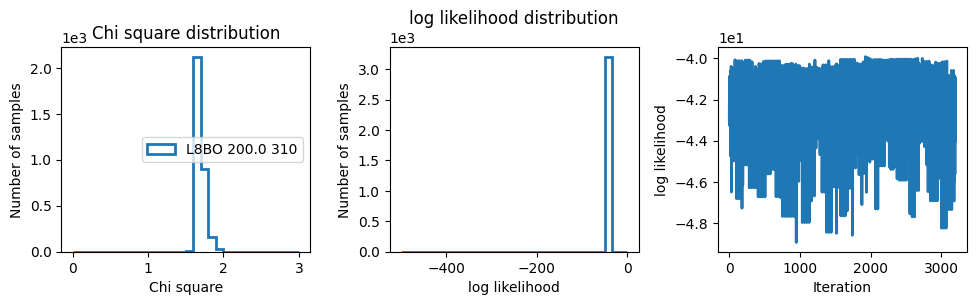

In [33]:
import importlib

importlib.reload(plot_utils)
index_analyse_list = [0]
fig, axes = plt.subplots(5, figsize=(10, 7))
for i, index_analyse in enumerate(index_analyse_list):
    test_id = df_all["test_id"].loc[index_analyse]
    label = (
        df_all["csv_name_pl"]
        .loc[index_analyse]
        .split("/")[-1]
        .replace(".csv", "")
        .replace("_mod_split", " ")
        .replace("_split", " ")
    )
    model_config, model_config_save = config_utils.load_model_config(
        test_id, database_folder="fit_experimental_emcee_pl/fit_data_base/"
    )
    filename = model_config_save["save_folder"] + "/sampler.h5"
    reader = emcee.backends.HDFBackend(filename, name="multi_core")
    fig, ax = plot_utils.plot_distribution_multi(
        reader,
        model_config_save,
        discard=200,
        filter_log_likelihood=True,
        fig=fig,
        axes=axes,
        color=f"C{i}",
        legend_label=label,
    )
fig, ax = plt.subplots(1, 3, figsize=(10, 3))
for i, index_analyse in enumerate(index_analyse_list):
    test_id = df_all["test_id"].loc[index_analyse]
    label = (
        df_all["csv_name_pl"]
        .loc[index_analyse]
        .split("/")[-1]
        .replace(".csv", "")
        .replace("_mod_split", " ")
        .replace("_split", " ")
    )
    model_config, model_config_save = config_utils.load_model_config(
        test_id, database_folder="fit_experimental_emcee_pl/fit_data_base/"
    )
    filename = model_config_save["save_folder"] + "/sampler.h5"
    reader = emcee.backends.HDFBackend(filename, name="multi_core")
    fig, ax = plot_utils.plot_fit_statistics_multi(
        reader,
        range_log_prior=(-500, 0),
        discard=200,
        range_chi_square=(0, 3),
        filter_log_likelihood=True,
        fig=fig,
        ax=ax,
        legend_label=label,
        color=f"C{i}",
    )